In [ ]:
# !pip install clip --quiet
# !pip install qdrant_client --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.3/206.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import clip
from qdrant_client import QdrantClient
import torch
import zipfile
from io import BytesIO

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Functions to perform text-to-image search using respective clip models

In [ ]:
# Images are stored in zip files
z1 = zipfile.ZipFile("/content/drive/My Drive/selected_images_1.zip")
files_in_zip_1 = z1.namelist()
z2 = zipfile.ZipFile("/content/drive/My Drive/selected_images.zip")
files_in_zip_2 = z2.namelist()

# files_1 = os.listdir("/content/drive/My Drive/selected_images")
# files_2 = os.listdir("C:/Users/dell/Desktop/selected_images_1")

In [ ]:
# Function to extract image from the given image path as PIL object
def get_image(image_path):
    if "selected_images_1/"+image_path in files_in_zip_1:
        image = Image.open(BytesIO(z1.read("selected_images_1/"+image_path)))

    elif "selected_images/"+image_path in files_in_zip_2:
        image = Image.open(BytesIO(z2.read("selected_images/"+image_path)))

    return image

In [ ]:
# Create input text(caption) embedding and pass it as a query vector to perform search
def text_to_image_search(model, text, client, collection):
    inp = tokenizer(text, return_tensors="pt")
    inp=inp.to(device)
    text_embeddings = model.get_text_features(**inp).cpu().detach().numpy().tolist()[0]
    hits = client.search(
        collection_name=collection,
        query_vector=("image",text_embeddings),
        limit=5,
        with_vectors=True
    )
    return hits

In [ ]:
# Function to display image from qdrant search results
def display_image_results(search_results, df):
    image_list = [get_image(df.loc[df['caption']==result.payload['caption'],'image_path'].values[0]) for result in search_results]
    caption_list = [result.payload['caption'] for result in search_results]
    for image,caption in zip(image_list,caption_list):
        print(caption)
        display(image.resize((224, 300)))

### Get image embeddings by original clip from vector database

In [ ]:
# Function to get CLIP model, processor and tokenizer
def get_model_info(model_ID, device):

    model = CLIPModel.from_pretrained(model_ID).to(device)
    processor = CLIPProcessor.from_pretrained(model_ID)
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)

    #return model, processor, tokenizer
    return model,processor, tokenizer

In [ ]:
# Get CLIP model, processor and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"

model_original,processor, tokenizer = get_model_info(model_ID, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
original_df=pd.read_csv("/content/drive/My Drive/preprocessed_selected_articles_clip.csv")
original_df['article_id'] = original_df['article_id'].astype(str)
original_df['article_id']=["0"+x for x in original_df['article_id']]

In [ ]:
original_df

,article_id,caption,image_path
0,0108775015,women's Solid Black Vest top,0108775015.jpg
1,0108775044,women's Solid White Vest top,0108775044.jpg
2,0108775051,women's Stripe Off White Vest top,0108775051.jpg
3,0111586001,women's Solid Black Leggings,0111586001.jpg
4,0116379047,women's Solid Dark Blue Top,0116379047.jpg
...,...,...,...
55168,0952937003,women's All over pattern Beige Dress,0952937003.jpg
55169,0952938001,women's All over pattern Beige Top,0952938001.jpg
55170,0953763001,women's Solid Black Vest top,0953763001.jpg
55171,0956217002,women's Solid Black Dress,0956217002.jpg


In [ ]:
# Connect to qdrant client
try:
    original_client = QdrantClient(
        url="https://c487cd09-8b2d-4c48-95cb-0bf3209ad30a.us-east4-0.gcp.cloud.qdrant.io:6333",
        api_key="wy51l0VFwIIaR_wu_pOaDEATBzLnCCxSrDG_uMFm1kSOozNByXKwlQ",
        timeout=None
    )
    print("client created successfully")

except QuadrantAPIError as e:
    # Handle API errors, if any
    print("Error creating Quadrant client:", e)
except Exception as e:
    # Handle any other unexpected errors
    print("An unexpected error occurred:", e)

client created successfully


In [ ]:
# Get collection info
original_client.get_collection(collection_name="image_embeddings_by_original_clip")

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=55173, indexed_vectors_count=49799, points_count=55173, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'image': VectorParams(size=512, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None), p

In [ ]:
text="mens red t shirt"
search_results_original = text_to_image_search(model_original, text, original_client, "image_embeddings_by_original_clip")

Solid Red T-shirt for male


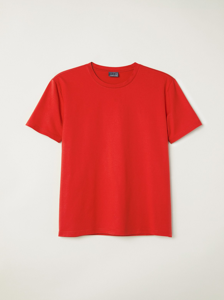

women's Solid Dark Orange Top


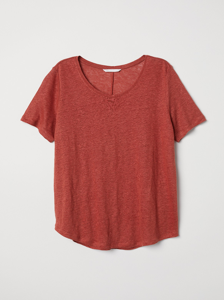

Solid Red T-shirt for male


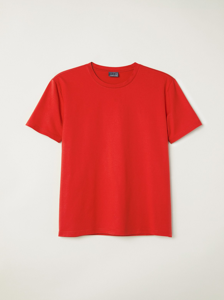

Solid Red T-shirt for male


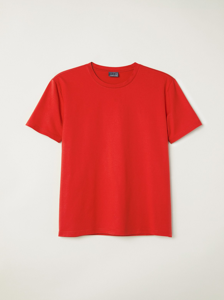

Melange Red T-shirt for male


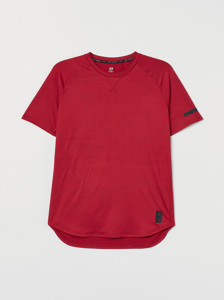

In [ ]:
display_image_results(search_results_original,original_df)

### Get image embeddings by finetuned clip from vector database

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"

model_finetuned,processor, tokenizer = get_model_info(model_ID, device)

In [ ]:
# Laoding finetuned model
model_finetuned_file=torch.load("/content/drive/My Drive/CLIP_finetuned_no_detail_desc.pth", map_location=device)
model_finetuned.load_state_dict(model_finetuned_file['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Connect to qdrant client
try:
    finetuned_client = QdrantClient(
        url="https://5647fd82-90a5-4a20-b099-68762d7b46ce.us-east4-0.gcp.cloud.qdrant.io:6333",
        api_key="Nz75e1xi7_YvMmO7BImqId2fNMMQjXPfhJwEwT_HTMOwPNPmqruAUw",
        timeout=None
    )
    print("client created successfully")

except QuadrantAPIError as e:
    # Handle API errors, if any
    print("Error creating Quadrant client:", e)
except Exception as e:
    # Handle any other unexpected errors
    print("An unexpected error occurred:", e)

client created successfully


In [ ]:
# Get collection info
finetuned_client.get_collection(collection_name="image_embeddings_by_finetuned_clip")

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=55173, indexed_vectors_count=50005, points_count=55173, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'image': VectorParams(size=512, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None), p

In [ ]:
text="mens red t shirt"
search_results_finetuned = text_to_image_search(model_finetuned, text, finetuned_client, "image_embeddings_by_finetuned_clip")

Placement print Red T-shirt


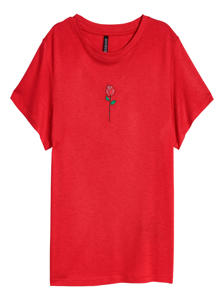

Solid Red T-shirt for male


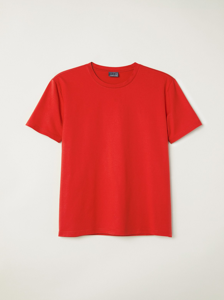

Solid Dark Pink T-shirt for male


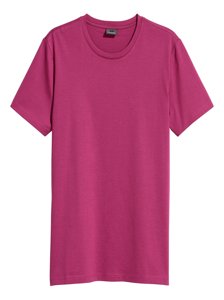

Placement print Red T-shirt


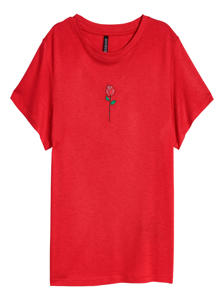

Solid Dark Orange T-shirt for male


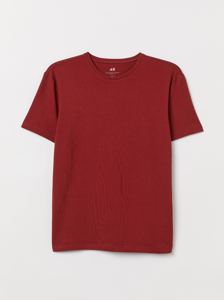

In [ ]:
display_image_results(search_results_finetuned,original_df)

### Evaluating model performances on test data

In [ ]:
import qdrant_client.http.models as models

# Search in vector database based on payload value
def text_to_image_search_testdata(text, client, collection):
  search_results = client.scroll(
      collection_name=collection,
      scroll_filter=models.Filter(
      must=[
          models.FieldCondition(
              key="caption",
              match=models.MatchValue(value=text),
          ),
      ]
      ),
      limit=1,
      with_vectors=True
  )
  return search_results

In [ ]:
# Display single image obtained from payload search results
def display_image_results_testdata(search_results, df):
    image = get_image(df.loc[df['caption']==search_results[0][0].payload['caption'],'image_path'].values[0])
    caption = search_results[0][0].payload['caption']
    print(caption)
    display(image.resize((224, 300)))

In [ ]:
import random

# Generate sets of testing indices
def generate_test_indices(test_data, num=50):
  random.seed(42)
  test_indices=[]
  other_indices=[]
  for i in range(num):
    test_index = random.randint(0, len(test_data)-1)
    other_index = [random.randint(0, len(test_data)-1) for i in range(100)]
    while True:
      if test_index in other_index:
        test_index = random.randint(0, len(test_data))
      else:
        break
    test_indices.append(test_index)
    other_indices.append(other_index)

  return test_indices, other_indices

In [ ]:
# Get cosine similarity between given image and text
def get_cosine_similarity(image_vector, text, model):

  inp = tokenizer(text, return_tensors="pt")
  inp=inp.to(device)
  text_embed = model.get_text_features(**inp).cpu().detach().numpy().tolist()[0]

  image_embed = torch.tensor(image_vector).view(1,512).to(device)
  image_embed = image_embed / image_embed.norm(p=2,dim=-1, keepdim=True)

  text_embed = torch.tensor(text_embed).view(1,512).to(device)
  text_embed = text_embed / text_embed.norm(p=2,dim=-1, keepdim=True)

  similarity = torch.nn.functional.cosine_similarity(text_embed, image_embed)

  return similarity

In [ ]:
# Compute performance metric
def compute_metric(test_cosim, other_cosim):
  return test_cosim - other_cosim

In [ ]:
# Import test data
test_data=pd.read_csv("/content/drive/My Drive/test_articles.csv")
test_data['article_id'] = test_data['article_id'].astype(str)
test_data['article_id']=["0"+x for x in test_data['article_id']]

In [ ]:
test_data

,article_id,caption,image_path
0,0116379047,women's Solid Dark Blue Top,0116379047.jpg
1,0118458004,Melange Grey Trousers for male,0118458004.jpg
2,0156610007,Solid Black Trousers for male,0156610007.jpg
3,0176209023,Solid Black Hoodie for male,0176209023.jpg
4,0176209039,Solid Greenish Khaki Hoodie for male,0176209039.jpg
...,...,...,...
11030,0941005004,Melange Grey Vest top,0941005004.jpg
11031,0941075001,women's Solid Black Vest top,0941075001.jpg
11032,0941454001,women's Solid Green Dress,0941454001.jpg
11033,0942506001,women's Solid Black Dress,0942506001.jpg


In [ ]:
# Get a random image from vector database
search_results_original_testdata=text_to_image_search_testdata(test_data['caption'][100],original_client, "image_embeddings_by_original_clip")

women's Solid Dark Orange Ballerinas


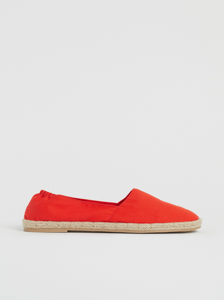

In [ ]:
display_image_results_testdata(search_results_original_testdata,test_data)

In [ ]:
# Get test indices
test_indices, other_indices=generate_test_indices(test_data)

### Testing on original clip model

In [ ]:
# Compute metric for each set of test indices
metrics=[]
for i in range(len(test_indices)):
  other_cosims=[]

  # Get a test image and its corresponding true caption
  test_caption=test_data['caption'][test_indices[i]]
  search_results_original_testdata=text_to_image_search_testdata(test_caption,original_client, "image_embeddings_by_original_clip")
  test_image=search_results_original_testdata[0][0].vector["image"]

  # Get cosine score between the test image and its true caption
  test_cosim=get_cosine_similarity(test_image, test_caption, model_original).item()

  # Get cosine scores between the test image and other captions
  for index in other_indices[i]:
    other_cosims.append(get_cosine_similarity(test_image, test_data['caption'][index], model_original).item())

  # Compute final metric
  metrics.append(compute_metric(test_cosim, np.mean(other_cosims)))

In [ ]:
# Average metric value
np.mean(metrics)

0.11000439820364118

### Testing on finetuned clip model

In [ ]:
# Compute metric for each set of test indices
metrics=[]
for i in range(len(test_indices)):
  other_cosims=[]

  # Get a test image and its corresponding true caption
  test_caption=test_data['caption'][test_indices[i]]
  search_results_finetuned_testdata=text_to_image_search_testdata(test_caption,finetuned_client, "image_embeddings_by_finetuned_clip")
  test_image=search_results_finetuned_testdata[0][0].vector["image"]

  # Get cosine score between the test image and its true caption
  test_cosim=get_cosine_similarity(test_image, test_caption, model_finetuned).item()

  # Get cosine scores between the test image and other captions
  for index in other_indices[i]:
    other_cosims.append(get_cosine_similarity(test_image, test_data['caption'][index], model_finetuned).item())

  # Compute final metric
  metrics.append(compute_metric(test_cosim, np.mean(other_cosims)))

In [ ]:
# Average metric value
np.mean(metrics)

0.1577704602379352